# 回帰　regression  
参考にしたやつ  
https://www.amazon.co.jp/Python%E3%81%A7%E5%8B%95%E3%81%8B%E3%81%97%E3%81%A6%E5%AD%A6%E3%81%B6%EF%BC%81-%E3%81%82%E3%81%9F%E3%82%89%E3%81%97%E3%81%84%E6%A9%9F%E6%A2%B0%E5%AD%A6%E7%BF%92%E3%81%AE%E6%95%99%E7%A7%91%E6%9B%B8-%E4%BC%8A%E8%97%A4-%E7%9C%9F/dp/4798144983  
  
https://www.atmarkit.co.jp/ait/articles/2006/04/news013.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib notebook

In [ ]:
# テストデータ作成　乱数固定
np.random.seed(seed=1)
x_min= 4
x_max = 30
x_n = 16

# 入力変数　年齢 （５～３０歳）
x = 5 + 25 * np.random.rand(x_n)
prm_c = [170, 108, 0.2]

# 目標変数　身長
t = prm_c[0] - prm_c[1] * np.exp(-prm_c[2] * x ) + 4 * np.random.randn(x_n)
np.savez('ch5_data.npz', x=x, x_min=x_min, x_max=x_max, x_n=x_n, t=t)

# テストデータプロット
plt.figure(figsize=(4,4))
plt.plot(x, t, marker='o', linestyle='None', markeredgecolor='black', color='cornflowerblue')
plt.xlim(x_min, x_max)
plt.grid(True)
plt.show()

大体こんな感じの線を引ければ良さそう  
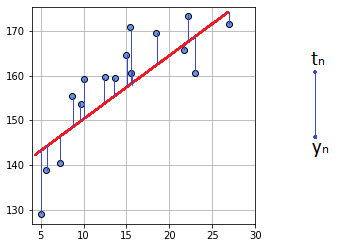
各々の点から直線への距離の合計値が一番小さくなるポイントを探す
つまり、
$$
J = \frac{1}{N} \sum_{n=0}^{N-1} (y_n - t_n)^2　 となる最小の𝐽を探す
$$

Jが最小のときの直線の式はこんな感じになる（回帰式）
$$
y = w_0x + w_1
$$

## なので、w0とw1さえわかれば、年齢から身長を予測可能

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

#平均二乗誤差関数 (MSE: Mean Squared Error) 
def mse_line(x, t, w):
    y = w[0] * x + w[1]
    mse = np.mean((y - t) ** 2)
    return mse

# 100 × 100通りの線を引いてみる
xn = 100
w0_range = [ -25, 25 ] 
w1_range = [ 120, 170 ]
w0 = np.linspace(w0_range[0], w0_range[1], xn)    #等差数列
w1 = np.linspace(w1_range[0], w1_range[1], xn)
j = np.zeros((len(w0), len(w1)))

# 10000通りの平均二乗誤差J, w0, w1を3Dでプロットしてみる
for i0 in range(len(w0)):
    for i1 in range(len(w1)):
        j[i1,i0] = mse_line(x, t, (w0[i0], w1[i1]))
plt.figure(figsize=(9.5, 4))
plt.subplots_adjust(wspace=0.5)
ax= plt.subplot(1,2,1, projection='3d')
ww0, ww1 = np.meshgrid(w0, w1)
ax.plot_surface(ww0, ww1, j, rstride=10, cstride=10, alpha=0.3, color='blue', edgecolor='black')
ax.set_xticks([-20, 0, 20])
ax.set_yticks([120,140,160])
ax.view_init(20, -60)

# jが最小となるのはどこか？ ⇒ 偏微分で求められる 

■解析解

$$
J = \frac{1}{N} \sum_{n=0}^{N-1} (y_n - t_n)^2 = \frac{1}{N} \sum_{n=0}^{N-1} (w_0x_n + w_1 - t_n)^2
$$

※ここで偏微分を使う！！！  （∂デル）  
①・・・ w0で偏微分して傾きが0（-> Jが最小）の場合の式はこうなる  
$$
\frac{∂J}{∂w_0} = \frac{2}{N} \sum_{n=0}^{N-1} (w_0x_n + w_1 - t_n)x_n = 0
$$
②・・・ w1で偏微分するとこうなる
$$
\frac{∂J}{∂w_1} = \frac{2}{N} \sum_{n=0}^{N-1} (w_0x_n + w_1 - t_n) = 0
$$
①と②の連立方程式を解けばw0, w1が求められる

In [ ]:
# 解析解　連立方程式を解く
def fit_line(x, t):
    mx = np.mean(x)
    mt = np.mean(t)
    mtx = np.mean(t * x)
    mxx = np.mean(x * x)
    w0 = (mtx - mt * mx ) / (mxx - mx**2)
    w1 = mt - w0 * mx
    
    return np.array([w0, w1])

## 連立方程式で解く場合、変数が増えると計算量も増えるので、いずれ計算不可能になる
## 機械学習では連立方程式を使わず、勾配法を使う
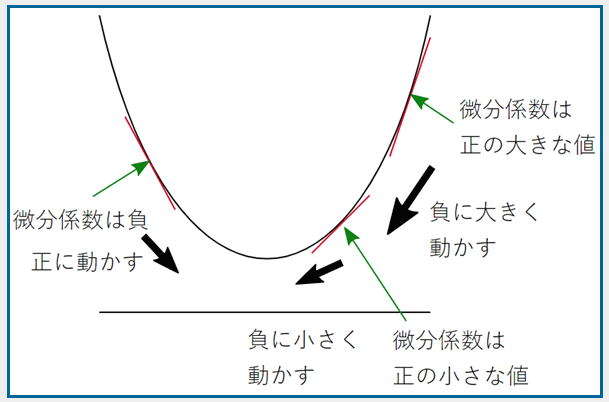

In [ ]:
# 平均二乗誤差の勾配
def dmse_line(x, t, w):
    y = w[0] * x + w[1]
    d_w0 = 2 * np.mean((y - t) * x)  # w0で偏微分
    d_w1 = 2 * np.mean(y - t)        # w1で偏微分
    return d_w0, d_w1

# 勾配法 
def fit_line_num(x, t):
    w_init = [10, 165]  # 初期値(適当)
    alpha = 0.001  # 学習率
    tau_max = 100000    # ループ最大数
    eps = 0.1    # ループ停止勾配閾値
    w_hist = np.zeros([tau_max, 2])
    w_hist[0,:] = w_init
    for tau in range(1, tau_max):
        # 勾配を求める
        dmse = dmse_line(x, t, w_hist[tau - 1])
        # w0, w1を少しずらす
        w_hist[tau, 0] = w_hist[tau - 1, 0] - alpha * dmse[0]
        w_hist[tau, 1] = w_hist[tau - 1, 1] - alpha * dmse[1]
        # 終了判定
        if max(np.absolute(dmse)) < eps:
            # print("np.absolute(dmse) ", np.absolute(dmse))
            break
    w0 = w_hist[tau, 0]
    w1 = w_hist[tau, 1]
    w_hist = w_hist[:tau, :]
    return w0, w1, dmse, w_hist


In [ ]:
# MSEの等高線表示
wn = 100
w0_range = [-25, 25]
w1_range = [120, 170]
w0 = np.linspace(w0_range[0], w0_range[1], wn)    #等差数列
w1 = np.linspace(w1_range[0], w1_range[1], wn)
ww0, ww1 = np.meshgrid(w0, w1)
j = np.zeros((len(w0), len(w1)))
for i0 in range(wn):
    for i1 in range(wn):
        j[i1,i0] = mse_line(x, t, (w0[i0], w1[i1]))

plt.figure(figsize=(4,4))
cont = plt.contour(ww0, ww1, j, 30, colors='black', levels=(100,1000,10000,100000))
cont.clabel(fmt='%1.0f', fontsize=8)

plt.grid(True)

W0, W1, dMSE, W_history = fit_line_num(x, t)
print("繰り返し回数 ", W_history.shape[0])
print("W = ", W0, W1)
print("MSE= ", dMSE)
#plt.plot(W_history[:,0], W_history[:,1], '.-', color='gray', markersize=10, markeredgecolor='cornflowerblue')
#plt.show()

In [ ]:
# 線の表示
def show_line(w):
    xb = np.linspace(x_min, x_max, 100)
    y = w[0] * xb + w[1]
    plt.plot(xb, y, color=(.5, .5, .5), linewidth=4)

plt.figure(figsize=(4,4))
w = np.array([W0, W1])
mse = mse_line(x, t, w)
print("平均二乗誤差 w0={0:.3f}, w1={1:.3f}".format(W0, W1))
print("標準偏差 SD={0:.3f} cm".format(np.sqrt(mse)))
show_line(w)
plt.plot(x, t, marker='o', linestyle='None', color='cornflowerblue', markeredgecolor='black')
plt.xlim(x_min, x_max)
plt.grid(True)
plt.show()

In [ ]:
# 解析解と勾配法の比較

W = fit_line(x, t)
print("解析解：", W)

W0, W1, dMSE, W_history = fit_line_num(x, t)
print("勾配法： ", [ W0, W1 ])

### ここまでは、入力変数１つ（年齢）で目標変数（身長）を予測してきた（単回帰）
### では、もう一つ入力変数（体重）を増やすとどうなるか？（重回帰）

In [ ]:
# 重回帰　サンプル作成

# 目標変数　身長   
T = t

# 入力変数0　年齢
X0 = x
X0_min = 5
X0_max = 30

# 入力変数1　体重
np.random.seed(seed = 1)
X1 = 23 * (t / 100)**2 + 2 * np.random.randn(x_n) # BMI平均が23と仮定
X1_min = 40
X1_max = 75

def show_data2(ax, x0, x1, t):
    for i in range(len(x0)):
        ax.plot([x0[i], x0[i]], [x1[i], x1[i]], [ 120, t[i]], color='gray')
    
    ax.plot(x0, x1, t, 'o', color='cornflowerblue', markeredgecolor='black', markersize=6, markeredgewidth=0.5)
    # 表示角度 elevはz軸方向から見た仰角，azimはx, y軸方向の方位角を指定
    ax.view_init(elev=35, azim=-75)

plt.figure(figsize=(6, 5))
ax = plt.subplot(1,1,1,projection='3d')
show_data2(ax, X0, X1, T)
plt.show()


In [ ]:
# 面の表示
def show_plane(ax, w):
    px0 = np.linspace(X0_min, X0_max, 5)
    px1 = np.linspace(X1_min, X1_max, 5)
    px0, px1 = np.meshgrid(px0, px1)
    y = w[0]*px0 + w[1]*px1 + w[2]
    ax.plot_surface(px0, px1, y, rstride=1, cstride=1, alpha=0.3, color='blue', edgecolor='black')
    
def mse_plane(x0, x1, t, w):
    y = w[0]*x0 + w[1]*x1 + w[2]
    mse = np.mean((y - t)**2)
    return mse

plt.figure(figsize=(6,5))
ax = plt.subplot(1, 1, 1, projection='3d')

W = [ 1.5, 1, 90]    # 最適なWを求める

show_plane(ax, W)
show_data2(ax, X0, X1, T)
mse = mse_plane(X0, X1, T, W)
plt.show()

単回帰の場合と同じように最小となるJを探せばよい
$$
    J = \frac{1}{N} \sum_{n=0}^{N-1} (W_0X_0 + W_1X_1 + W_2 - t_n)^2　　
$$
回帰式
$$
    y = W_0x_0 + W_1x_1 + W_2
$$

In [ ]:
# 解析解　連立方程式を解く

def fit_plane(x0, x1, t):
    c_tx0 = np.mean(t * x0) - np.mean(t) * np.mean(x0)
    c_tx1 = np.mean(t * x1) - np.mean(t) * np.mean(x1)
    c_x0x1 = np.mean(x0 * x1) - np.mean(x0) * np.mean(x1)
    v_x0 = np.var(x0)
    v_x1 = np.var(x1)
    w0 = (c_tx1 * c_x0x1 - v_x1 * c_tx0) / (c_x0x1**2 - v_x0 * v_x1)
    w1 = (c_tx0 * c_x0x1 - v_x0 * c_tx1) / (c_x0x1**2 - v_x0 * v_x1)
    w2 = -w0 * np.mean(x0) - w1 * np.mean(x1) + np.mean(t)
    return np.array([w0, w1, w2])


In [ ]:
# 2次元入力時の勾配法 

def dmse_line2(x0, x1, t, w):
    # 𝑦=w0𝑥0 + w1𝑥1 + w2
    y = w[0] * x0 + w[1] * x1 + w[2] 
    
    d_w0 = 2 * np.mean((y - t) * x0)  # w0で偏微分
    d_w1 = 2 * np.mean((y - t) * x1)  # w1で偏微分
    d_w2 = 2 * np.mean(y - t)         # w2で偏微分
    
    return d_w0, d_w1, d_w2

def fit_line_num2(x0, x1, t):
    w_init = [1.5, 1, 90]  # 初期値(適当)
    
    # 学習率  0.001 と 0.00001 にも変えてみて動きを確かめてみよう
    alpha = 0.0001  
    
    tau_max = 100000    # ループ最大数
    eps = 0.1    # ループ停止勾配閾値
    w_hist = np.zeros([tau_max, 3])
    w_hist[0,:] = w_init
    for tau in range(1, tau_max):
        # 勾配を求める
        dmse = dmse_line2(x0, x1, T, w_hist[tau - 1])
        # w0, w1, w2を少しずらす
        w_hist[tau, 0] = w_hist[tau - 1, 0] - alpha * dmse[0]
        w_hist[tau, 1] = w_hist[tau - 1, 1] - alpha * dmse[1]
        w_hist[tau, 2] = w_hist[tau - 1, 2] - alpha * dmse[2]
        #print("##### w_hist[tau]: ", w_hist[tau])
        # 終了判定
        if max(np.absolute(dmse)) < eps:
            #print("np.absolute(dmse) ", np.absolute(dmse))
            break
    w0 = w_hist[tau, 0]
    w1 = w_hist[tau, 1]
    w2 = w_hist[tau, 2]
    w_hist = w_hist[:tau, :]
    return [ w0, w1, w2 ] , dmse, w_hist


In [ ]:
# 解析解と勾配法の比較をしてみる

W = fit_plane(X0, X1, T)
print("解析解：", W)

W, dMSE, W_history = fit_line_num2(X0, X1, t)
print("勾配法：", W)